Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the Bomb Calorimetry Experiment {-}

## Preliminary Setup {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [96]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression


# The following needs to be the path of the folder with all your datafile in .csv format
base_path = '/Users/School/PycharmProjects/PChemLab/Bomb_Data/Bomb Cal'

The following functions have been developed to help you load and visualize the bomb calorimetry data. You do not need to understand how these functions work now, we will cover it step by step later on.

In [97]:
# @title Functions to load the data { display-mode: "form" }

def get_sec(time_str):
    """
    Convert a time string in HH:MM:SS format into an integer number of seconds
    
    Input variables:
        time_str : a string with a time in HH:MM:SS format

    Output:
        time : the integer number of seconds corresponding to the input time_str
    """
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

def load_data_to_file_dict(file_dict):
    """
    Load a bomb calorimetry .csv file. 
    The format of the file should have the first column with time in HH:MM:SS format and 
    the second column with the recorded temperature. Any additional column is discarded

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to file_dict a Pandas DataFrame with two columns: time (in seconds) and temperature (in input units)   
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],usecols=(0,1),names=['hh:mm:ss','temperature'])
    data['time'] = data['hh:mm:ss'].apply(get_sec)
    data = data.drop(columns=['hh:mm:ss'])
    file_dict['data'] = data
    return

def load_data_to_file_list(file_list):
    """
    Given a list of dictionary files, recursively use load_data_to_file_dict to load the data into each of the dictionaries

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to each file_dict a Pandas DataFrame with two columns: time (in seconds) and temperature (in input units)   
    """
    for f in file_list : 
        if not ('data' in f): load_data_to_file_dict(f)
    return

def plot_file_dict(file_dict):
    """
    Given a dictionary file of a bomb calorimetry experiment, plot temperature vs. time.

    Input variables:
        file_dict : a dictionary file with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Plot temperature vs. time for the selected file 
    """
    fig, ax = plt.subplots()
    if not ('data' in file_dict): 
        load_data_to_file_dict(f)
    file_dict['data'].plot('time','temperature',label=file_dict['name'],ax=ax)
    plt.xlabel('Time (s)')
    plt.ylabel(r'Temperature ($^{\circ}$C)')
    plt.show()

def plot_by_key(file_list,key='',value=['']):
    """
    Given a list of dictionary files, plot temperature vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files
    
    Action: 
        Plot temperature vs. time for the selected files  
    """
    if value == '' or key == '':
        file_shortlist = file_list
    else :
        file_shortlist = [f for f in file_list if f[key] in value ]
    fig, ax = plt.subplots()
    for f in file_shortlist : 
        if not ('data' in f): 
            load_data_to_file_dict(f)
        f['data'].plot('time','temperature',label=f['name'],ax=ax)
    plt.xlabel('Time (s)')
    plt.ylabel(r'Temperature ($^{\circ}$C)')
    plt.show()

The following functions are designed to automate the identification of important points in the bomb calorimetry plots. You do not need to understand how these functions work now, we will cover it step by step later on.

In [98]:
# @title Functions to automate the identification of special points { display-mode: "form" }

def get_time_skip(file_dict,recursive = False):
    if not ('data' in file_dict) :
        load_data_to_file_dict(file_dict)
    if file_dict['time_skip'] == 0 : 
        time_skip = 0
    else:
        time_skip = file_dict['time_skip']
    data = file_dict['data']
    clean_data = data[data['time']>time_skip]
    if recursive :
        return time_skip, clean_data
    else :
        return time_skip

def get_time_ignition(file_dict,recursive = False):
    time_skip, data = get_time_skip(file_dict,True)
    if file_dict['time_ignition'] == 0:
        temperatures=data['temperature'].values
        times=data['time'].values
        derivatives = np.zeros(temperatures.shape)
        derivatives[1:-1] = np.convolve(temperatures,[1,-2,1],'same')[1:-1]
        ignition_index = np.argmax(derivatives)
        time_ignition = times[ignition_index-1]
    else :
        time_ignition = file_dict['time_ignition']
    if recursive :
        return time_skip, time_ignition, data
    else :
        return time_ignition

def get_time_exponential(file_dict,recursive = False):
    time_skip, time_ignition, data = get_time_ignition(file_dict, True)
    if file_dict['time_exponential'] == 0:
        times = data['time'].values
        temperatures = data['temperature'].values
        time_exponential = times[np.argmax(temperatures)]
    else : 
        time_exponential = file_dict['time_exponential']
    if recursive : 
        return time_skip, time_ignition, time_exponential, data
    else :
        return time_exponential

def get_time_post(file_dict, recursive = False):
    time_skip, time_ignition, time_exponential, data = get_time_exponential(file_dict, True)
    if file_dict['time_post'] == 0 :
        temperatures = data['temperature'].values
        exponential_data = data.query('time > {} and time < {}'.format(time_ignition,time_exponential))
        exponential_lr = LinearRegression()
        exp_x = exponential_data['time'].values.reshape(-1,1)
        exp_y = np.log(np.max(temperatures) - exponential_data['temperature'].values)
        exponential_lr.fit(exp_x,exp_y)
        rate = -exponential_lr.coef_[0]
        time_post = time_ignition + 6/rate
        if time_post > data['time'].iloc[-1] : 
            # if we overshoot time_post, just choose six points to fit the postignition linear drift
            time_post = data['time'].iloc[-6]
    else :
        time_post = file_dict['time_post']
    if recursive : 
        return time_skip, time_ignition, time_exponential, time_post, data
    else :
        return time_post

The following functions are designed to allow you to check if the data and the fits are reasonable. 

In [99]:
# @title Functions to check your data { display-mode: "form" }

def check_time_skip(file_dict):
    time_skip, time_ignition, data = get_time_ignition(file_dict, True)
    full_data = file_dict['data']
    full_preignition_data = full_data[ full_data['time'] <= time_ignition ]
    full_preignition_times = full_preignition_data['time'].values
    full_preignition_temperatures = full_preignition_data['temperature'].values
    preignition_data = data[data['time'] <= time_ignition]
    preignition_lr = LinearRegression()
    pre_x = preignition_data['time'].values.reshape(-1,1)
    pre_y = preignition_data['temperature'].values
    preignition_lr.fit(pre_x,pre_y)
    preignition_temperatures_fit = preignition_lr.predict(full_preignition_times.reshape(-1,1))
    preignition_score = preignition_lr.score(pre_x,pre_y)
    plt.plot(full_preignition_times,full_preignition_temperatures)
    plt.plot(full_preignition_times,preignition_temperatures_fit,color='r')
    plt.plot(pre_x,pre_y,'o',color='r')
    plt.ylabel(r'Temperature ($^{\circ}$C)')
    plt.xlabel('Time (s)')
    return "Given a time_skip of {}, the linear fit has a R2 of {}".format(time_skip,preignition_score)

def check_time_ignition(file_dict):
    time_skip, time_ignition, data = get_time_ignition(file_dict, True)
    data = file_dict['data']
    time_step = data['time'].values[1]-data['time'].values[0]
    temperature_ignition = data[data['time']==time_ignition]['temperature'].values[0]
    preignition_data = data[ data['time'] < time_ignition + 4*time_step ]
    preignition_times = preignition_data['time'].values
    preignition_temperatures = preignition_data['temperature'].values
    plt.plot(preignition_times,preignition_temperatures,'o-')
    plt.ylabel(r'Temperature ($^{\circ}$C)')
    plt.xlabel('Time (s)')
    plt.annotate('Estimated Ignition Time\n t = {}'.format(time_ignition), xy=(time_ignition, temperature_ignition), xytext=(time_ignition-200, temperature_ignition+0.3),
            arrowprops=dict(facecolor='black', shrink=0.05))
    return

def check_exponential_fit(file_dict, semilog=False):
    time_skip, time_ignition, time_exponential, data = get_time_exponential(file_dict, True)
    temperature_exponential = np.max(data['temperature'])
    exponential_data = data.query('time > {} and time < {}'.format(time_ignition,time_exponential))
    exponential_lr = LinearRegression()
    exp_x = exponential_data['time'].values.reshape(-1,1)
    exp_y = np.log(temperature_exponential - exponential_data['temperature'].values)
    exponential_lr.fit(exp_x,exp_y)
    exponential_score = exponential_lr.score(exp_x,exp_y)
    rate = -exponential_lr.coef_[0]
    if semilog :
        plt.plot(exp_x,exp_y,'o')
        plt.plot(exp_x,exponential_lr.predict(exp_x),'-')
        plt.ylabel('Log(Tmax-T)')
        plt.xlabel('Time (s)')
    else:
        plt.plot(exp_x,exponential_data['temperature'].values,'o')
        plt.plot(exp_x,temperature_exponential-np.exp(exponential_lr.predict(exp_x)),'-')
        plt.ylabel(r'Temperature ($^{\circ}$C)')
        plt.xlabel('Time (s)')
    return "Given a time_exponential of {} and a time_ignition of {}, the exponential fit has a R2 of {}".format(time_exponential,time_ignition,exponential_score)

def check_time_post(file_dict): 
    time_skip, time_ignition, time_exponential, time_post, data = get_time_post(file_dict, True)
    postignition_data = data[ data['time'] > time_post ]
    postignition_lr = LinearRegression()
    post_x = postignition_data['time'].values.reshape(-1,1)
    post_y = postignition_data['temperature'].values
    postignition_lr.fit(post_x,post_y)
    postignition_score = postignition_lr.score(post_x,post_y)
    plt.plot(post_x,post_y,'o')
    plt.plot(post_x,postignition_lr.predict(post_x))
    plt.ylabel(r'Temperature ($^{\circ}$C)')
    plt.xlabel('Time (s)')
    return "Given a time_post of {}, the linear fit has a R2 of {}".format(time_post,postignition_score)        

This is the main function that we will use to get the temperature jump for our experimental data.

In [100]:
# @title Main function to fit bomb calorimetry data { display-mode: "form" }

def get_deltaT(file_dict,verbose=False,plot=False):
    
    time_skip, time_ignition, time_exponential, time_post, data = get_time_post(file_dict,True)

    times = data['time'].values
    temperatures = data['temperature'].values
    if plot : 
        plt.plot(times,temperatures)
        plt.ylabel(r'Temperature ($^{\circ}$C)')
        plt.xlabel('Time (s)')

    preignition_data = data[ data['time'] < time_ignition ]
    preignition_lr = LinearRegression()
    pre_x = preignition_data['time'].values.reshape(-1,1)
    pre_y = preignition_data['temperature'].values
    preignition_lr.fit(pre_x,pre_y)
    Ti = preignition_lr.predict([[time_ignition]])[0]
    temperatures_preignition = preignition_lr.predict(times.reshape(-1,1))
    if plot : plt.plot(times,temperatures_preignition,':',color='k')

    exponential_data = data.query('time >= {} and time < {}'.format(time_ignition,time_exponential))
    Te = np.max(data['temperature'])
    exponential_lr = LinearRegression()
    exp_x = exponential_data['time'].values.reshape(-1,1)
    exp_y = np.log(Te - exponential_data['temperature'].values)
    exponential_lr.fit(exp_x,exp_y)
    rate = -exponential_lr.coef_[0]
    time_determination = time_ignition + 1/rate
    temperatures_exponential = Te - np.exp(exponential_lr.predict(exp_x))
    if plot : plt.plot(exp_x,temperatures_exponential,':',color='k')

    postignition_data = data[ data['time'] > time_post ]
    postignition_lr = LinearRegression()
    post_x = postignition_data['time'].values.reshape(-1,1)
    post_y = postignition_data['temperature'].values
    postignition_lr.fit(post_x,post_y)
    Tf = postignition_lr.predict([[time_post]])[0]
    temperatures_postignition = postignition_lr.predict(times.reshape(-1,1))
    if plot : plt.plot(times,temperatures_postignition,':',color='k')

    Tmax = np.max(temperatures)
    tmax = times[np.argmax(temperatures)]
    Tmin = np.min(temperatures)
    tmin = times[np.argmin(temperatures)]
    deltaT_max = Tmax - Tmin
    if verbose and plot : 
        plt.plot([tmax,tmin],[Tmax,Tmin],'o',color = 'C3')
        plt.plot([tmin,tmax],[Tmin,Tmin],':',color = 'C3')
        plt.plot([tmax,tmax],[Tmin,Tmax],color = 'C3')

    deltaT = Tf - Ti
    if verbose and plot : 
        plt.plot([time_ignition,time_post],[Ti,Tf],'o',color='C1')
        plt.plot([time_ignition,time_post],[Ti,Ti],':',color='C1')
        plt.plot([time_post,time_post],[Ti,Tf],color='C1')

    Ti_corrected = preignition_lr.predict(np.array([[time_determination]]))[0]
    Tf_corrected = postignition_lr.predict(np.array([[time_determination]]))[0]
    deltaT_corrected = Tf_corrected - Ti_corrected
    if plot : plt.plot(np.ones(2)*time_determination,[Ti_corrected,Tf_corrected],'o-',color='k')
    if verbose : 
        print("The corrected deltaT is {:7.4f}\nThe uncorrected deltaT is {:7.4f}\nThe maximum deltaT from the data is {:7.4f}".format(deltaT_corrected, deltaT, deltaT_max))
        return
    else :
        return deltaT_corrected

## Visualize the Systems

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [101]:
# @title Install and load RDKit { display-mode: "form" }
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
!pip install cirpy
import cirpy

In particular we can use them to draw the molecules in our experiments. While for some molecules you can just write their names and RDKit will plot them, for most molecules you will need to provide their SMILES or their CAS numbers.  Luckily, CIRpy can usually find SMILES for you, if you type the common name correctly or if you know the CAS number. 

These are the SMILES for the molecules in your bomb calorimetry experiments:
* Benzoic Acid: 'O=C(O)c1ccccc1'
* Cyclopropane Carboxylic Acid: 'C1CC1C(=O)O'
* 1,4-Cyclohexane Dicarboxylic Acid: 'C1CC(CCC1C(=O)O)C(=O)O'

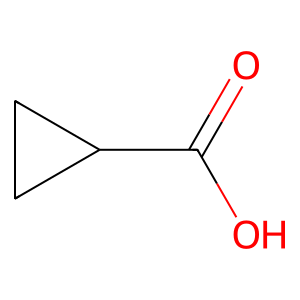

In [102]:
# @title Choose the molecule to draw { display-mode: "form" }
input = 'Cyclopropane Carboxylic Acid' # @param {type:"string"}
input_type = 'name' # @param ["smiles", "name", "cas"] {allow-input: true}
if input_type != 'smiles' :
    smiles=cirpy.resolve( input, 'smiles')
else:
    smiles=input
img = Draw.MolToImage( Chem.MolFromSmiles(smiles), size=(300, 300) )
display(img)

## Load and Visualize the First Experiment

We need to load the Google Drive and access an example of a dataset from a calorimetry experiment. You can use the same set that I am using by downloading it from Canvas, [here](https://boisestatecanvas.instructure.com/courses/20544/files/10204027?wrap=1). Or you can use your own files. I am assuming the file in question will be located in a `Bomb_Data/` subfolder in your `Colab Notebook/` folder. 

In [103]:
# @title Set Local Path { display-mode: "form" }
# The following needs to be the path of the folder with all your collected data in .csv format

path = '/Users/School/PycharmProjects/PChemLab/Bomb_Data/Bomb Cal/'

In order to streamline the fitting of the data, we will be storing the file that corresponds to each experiment into a Python dictionary (`dict`), together with all the relevant information of that experiment and the parameters that we need for the fit. You can use the same statement in the following, but make sure to change the file name from `BA1.csv` (the one that I am using) to the one you want to use.

In [104]:
file1 = {'path':path, 'name':'BA1.txt', 'set':'calibration', 'mass':0., 'time_skip':0, 'time_ignition': 0, 'time_exponential': 0, 'time_post': 0}

We can now use one of the functions designed for this lab to read the file and save the data as a `Pandas.DataFrame` in an entry of the dictionary. Under the hood, we will be using the `pd.read_csv()` function. Note that the file in question has multiple columns and no labels for the columns. The first column should contain the time of the experiment in a HH:MM:SS format, the second column should contain the temperature recorded by the calorimeter, the other columns contain other information that we will not need. If your files are not consistent with this format, we will need to adjust the script appropriately.

In [105]:
load_data_to_file_dict(file1)
file1['data'].head()

,temperature,time
0,1.31,0
1,1.31,10
2,1.31,20
3,1.31,30
4,1.31,40


`Pandas` allows to directly plot the data using `Matplotlib`, but for this lab you can use a function designed to work on dictionary similar to the one we just created. 

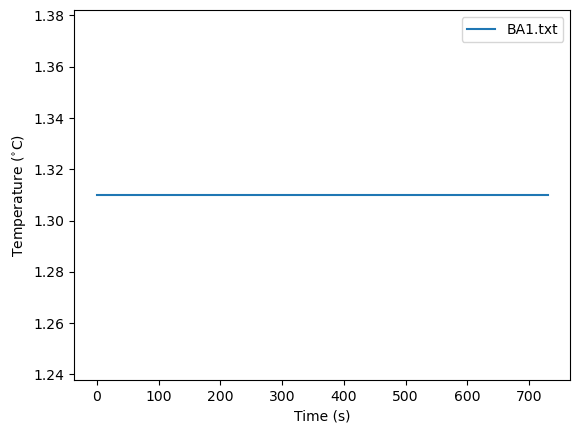

In [106]:
plot_file_dict(file1)

How can we extract the jump in temperature during combustion from this curve?

There are simple more hand-wavy strategies and more scientifically motivated approaches. Which one should we use?

In [107]:
get_deltaT(file1,verbose=True,plot=True)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

## Fitting the Experiment {-}

There are four regimes in a typical bomb calorimetry curve:
* some shorter or longer transient regime at the beginning of the curve
* a linear drift (with positive slope) in temperature in the pre-ignition part
* an exponential growth during combustion
* a linear drift (with positive or negative slope) in the post-ignition part

Why these different trend? How do they affect our determination of the temperature jump?

In the dictionary that we setup for our experiment there are four parameters that are related to the fitting procedure. 
* time_skip
* time_ignition
* time_exponential
* time_post

Each of these parameters is related to the different regimes we saw before. We designed functions to estimate these parameters in an automated way. However, nothing really works 100% of the times and it may be that you need to adjust some of these parameters to improve the fit.

The very first part of the experiment is clearly not as clean and stable as we would need. We can assume there is an initial transient time that we need to wait before being able to use our data. Removing the transient part of the data will significantly improve the determination of the temperature jump. We can decide how much to skip by checking how well we can perform a linear fit of pre-ignition regime.

In [ ]:
# @title Try changing time_skip to see how good the fit becomes { display-mode: "form" }
time_skip = 0 # @param {type:"integer"}
file1['time_skip'] = time_skip
check_time_skip(file1)

Play with the commands above until you find a value of `time_skip` that you feel is adequate for your data. Once you have found it, try to re-run the calculation of the temperature jump and see how much it changed your results.

In [ ]:
get_deltaT(file1,verbose=True,plot=True)

To find the ignition time we can use math and try to identify the part of the curve with a kink. Can you think at what property of the curve we can use?

However, as stated above, sometimes errors in the calculations with a discrete dataset produce a not exact determination of the ignition time. It is a good practice to check that the value that you get by default is indeed the correct one.

In [ ]:
# @title Check if the default time_ignition looks good { display-mode: "form" }
time_ignition = 0 # @param {type:"integer"}
file1['time_ignition'] = time_ignition
check_time_ignition(file1)

The next regime of the experiment is a growth in the temperature that follows an exponential function: $T(t) = T_f - (T_f - T_i) e^{-k(t-t_i)}$. This is a non-linear function, but we can still perform a linear regression if we apply a transformation to linearize it, i.e., if we fit $\log\left({T_f-T(t)}\right)$. Is this trick safe to play? What can go wrong?

In [ ]:
# @title Adjust time_exponential { display-mode: "form" }
time_exponential = 0 # @param {type:"integer"}
semilog = False # @param {type:"boolean"}
file1['time_exponential'] = time_exponential
check_exponential_fit(file1,semilog=semilog)

When you look at the fit in a semilog scale you will see that it gets worse towards the end. To improve the fit, we can select a better `time_exponential` to stop the fit. 

Eventually, we need to select a point in the experiment (`time_post`) where the combustion is fully over and the temperature is again drifting with a linear slope. We can choose the post-ignition time as we like, provided it is in the linear drift region of the data. By default, the code will use the knowledge of the exponential decay rate to take a time when the exponential function is virtually zero. However, this point may fall outside of the range of times of your experiment or it may still not be good enough. 

In [ ]:
# @title Check if the default time_post looks good { display-mode: "form" }
time_post = 0 # @param {type:"integer"}
file1['time_post'] = time_post
check_time_post(file1)

Now that we have determined all the parameters of the fit, we can check again how much they change the final results.

In [ ]:
get_deltaT(file1,verbose=True,plot=True)

## Check Each of Your Experiments

Repeat this analysis for each one of your curves. Make sure to take note of the times that affect your analysis the most, you will need them in your worksheet. By selecting the type of check from the dropdown list, you can see the effect of the parameters on the whole fit or on the individual parts of the experiment.

In [ ]:
# @title Choose a new file and identify good values for the fitting times { display-mode: "form" }
filename = '' # @param {type:"string"}
time_skip = 0 # @param {type:"integer"}
time_ignition = 0 # @param {type:"integer"}
time_exponential = 0 # @param {type:"integer"}
time_post = 0 # @param {type:"integer"}
check_type = 'skip' # @param ['full','skip','ignition','exponential','post'] {allow-input: true}
semilog = False # @param {type:"boolean"}
newfile = {'path':path, 'name':filename, 'set':'calibration', 'mass':0., 'time_skip':time_skip, 'time_ignition': time_ignition, 'time_exponential': time_exponential, 'time_post': time_post}
if check_type == 'full':
    get_deltaT(newfile,verbose=True,plot=True)
elif check_type == 'skip':
    check_time_skip(newfile)
elif check_type == 'ignition':
    check_time_ignition(newfile)
elif check_type == 'exponential':
    check_exponential_fit(newfile,semilog)
elif check_type == 'post':
    check_time_post(newfile)